In [ ]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import shap
from catboost import CatBoostClassifier, Pool, metrics, cv, CatBoostRegressor
from pandas_profiling import ProfileReport
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error,make_scorer,roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier
from yellowbrick.regressor import prediction_error, PredictionError

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
pio.renderers.default = 'colab'
pio.templates.default = 'ggplot2'

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-uci/heart.csv


<a id="introduction"></a>
# **1. Introduction** ⚕

<div style="text-align:center"><img src="https://www.indushealthplus.com/media/article_img/heart-disease-thumb.jpg" title="Heart Disease">

Predicting serious disease from each patient based on particular test results and or risk factors is one of the popular application of machine learning due to its major benefits. Patients who get prediction with certain diseases could be treat earlier to prevent the disease from getting worse. Besides, understanding how the features affect the prediction could help to create prescriptive analysis to minimize the risks.

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date.

Since most of the variables sounds unfamiliar for people without medical background, we will start with data understanding of each features to help the analysis. Subsequently, EDA and modelling are applied before model interpretation in the last part.

# **2. Data Understanding** 📖

In [ ]:
df = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')

In [ ]:
df.describe()

age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

             thal      target  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

The ca has 5 out-of-range values, which is 4 where the given range is 0-3. If we take a look in the original dataset posted [here](https://archive.ics.uci.edu/ml/datasets/heart+disease), they are supposed to be missing values. Considering the insignificance of the number to the whole dataset, the records then will be removed.

Besides, some of the data have different values with the original dataset, which are row 48 and 281 where the values of variable should be NA instead of 0. For the same reason, the rows will be dropped.

Finally, after checking and comparing the data against the original and doing the EDA, the values of target seems to be misplaced where 0 means a person is diagnosed with heart disease, instead of 1. Thus, the values of target will be exchanged.

In [ ]:
df_clean = df.drop([48,281], axis=0)
df_clean = df_clean.drop(df_clean[df_clean['ca']==4].index)
df_clean['target'].replace({0:1,1:0}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


The dataset has 13 features to predict the target whether the observed patient is diagnosed with heart disease or not. Some of the features are quite obscure, especially for those without prior medical knowledge. In order to understand each variable to ease the data analysis, I have searched simple explanation from multiple sources.

Variable Explanation :
1. **`age`** : person's age in years
2. **`sex`** : person's gender
    * *0 = female*
    * *1 = male*

3. **`cp`** : chest pain
    * *0 = asymptomatic*
        
        Showing no sign of symptoms. Nearly half of all heart attacks have no symptoms at all. They are described as silent because when they occur, their symptoms lack the intensity of a classic heart attack, such as extreme chest pain and pressure; stabbing pain in the arm, neck, or jaw; sudden shortness of breath; sweating, and dizziness. [Source](https://www.health.harvard.edu/heart-health/the-danger-of-silent-heart-attacks)

    * *1 = atypical angina*

        Atypical (probable) angina chest pain applies when 2 out of 3 criteria of typical angina are present, which are further explained in typical angina. [Source](https://www.timeofcare.com/typical-vs-atypical-chest-pain)
    
    * *2 = non anginal pain*

        Chest pain that is not caused by angina. [Source](https://my.clevelandclinic.org/health/diseases/15851-gerd-non-cardiac-chest-pain)

    * *3 = typical angina*
    
        Angina is a type of chest pain caused by reduced blood flow to the heart, which also called angina pectoris. It is often described as squeezing, pressure, tightness or pain in the chest. Typical (classic) angina chest pain consists of (1) Substernal chest pain or discomfort that is (2) Provoked by exertion or emotional stress and (3) relieved by rest or nitroglycerine (or both). [Source](https://www.timeofcare.com/typical-vs-atypical-chest-pain)

4. **`trestbps`** : resting blood pressure (in mm Hg on admission to the hospital)

 Blood pressure is the pressure of blood pushing against the walls of the arteries. High blood pressure, also called hypertension, is blood pressure that is higher than normal. The higher the blood pressure levels, the more risk for other health problems, such as heart disease, heart attack, and stroke. [Source](https://www.cdc.gov/bloodpressure/about.htm)

5. **`chol`** : serum cholesterol in mg/dl

 Cholesterol is required to build cells and make vitamins and other hormones. But too much cholesterol can pose a problem. When there is too much cholesterol in the blood, it builds up in the walls of the arteries. The arteries become narrowed and blood flow to the heart muscle is slowed down or blocked. The blood carries oxygen to the heart, and if not enough blood and oxygen reach your heart, you may suffer chest pain. If the blood supply to a portion of the heart is completely cut off by a blockage, the result is a heart attack. [Source](https://www.webmd.com/heart-disease/guide/heart-disease-lower-cholesterol-risk)

6. **`fbs`** : fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)

 This measures blood sugar level after an overnight fasting. People with a fasting blood sugar level of 100-125 mg/dl has an adjusted nearly 300% increase higher risk of having coronary heart disease than people with a level below 79 mg/dl. [Source](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451)

7. **`restcg`** : resting electrocardiographic results

 Resting electrocardiography (ECG) is performed while patient lying down in a comfortable position. During this time, a series of electrodes, attached to your skin with small sticky pads, will be recording the electrical activity going on in your heart.

 The information they gather is transmitted back to the ECG machine, which will produce a chart or electrocardiogram showing how the electrical activity changes over time. When we look at this rest ECG chart, we can identify peaks and valleys that show when the upper and lower chambers of your heart are contracting and relaxing.

 Specific heart disorders can produce recognisable patterns on the ECG. It can be used to investigate symptoms of a possible heart problem, such as chest pain, palpitations (suddenly noticeable heartbeats), dizziness and shortness of breath. [Source](https://www.nhs.uk/conditions/electrocardiogram/)

 The compositions of ECG results are displayed below :
<div style="text-align:center"><img src="https://ekg.md/wp-content/uploads/2018/02/Pediatric-ST-Segment-e1523655945228.jpg" title="ECG results composition" width="250" height="220">

    * *0 = showing probable or definite left ventricular hypertrophy by Estes' criteria*

        Left ventricular hypertrophy (LVH) is a term for a heart’s left pumping chamber that has thickened and may not be pumping efficiently. LVH is the most potent predictor of adverse cardiovascular outcomes in the hypertensive population, and is an independent risk factor for coronary heart disease, sudden death, heart failure and stroke. [Source](https://www.heart.org/en/health-topics/heart-valve-problems-and-disease/heart-valve-problems-and-causes/what-is-left-ventricular-hypertrophy-lvh)

    * *1 = normal*
        
        If the heart is healthy, the peaks will form a characteristic pattern and they will occur at a regular rate of between 60 and 100 beats per minute. [Source](https://www.cardiacscreen.co.uk/rest-ecg.php)

    * *2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)*

        T-wave inversions with concomitant ST-segment deviations is typical of ischemia. However, it is actually the ST-segment deviations that reflects the ischemia, which is a restriction in blood supply to any tissues, muscle group, or organ of the body, causing a shortage of oxygen. When arteries are narrowed, less blood and oxygen reaches the heart muscle. This is also called coronary artery disease and coronary heart disease that could lead to heart attack. [Source](https://ecgwaves.com/topic/t-wave-negative-inversions-hyperacute-wellens-sign-de-winters/)


8. **`thalach`**: The person's maximum heart rate achieved

 The heart rate, or pulse, is the number of times the heart beats in 1 minute. Heart rates vary from person to person. It’s lower when you’re at rest and higher when you exercise. Maximum heart rate is the fastest the heart can beat and still pump blood effectively through the body. As you age, your maximum heart rate drops. This means that your heart is weaker and more susceptible to damage, and you can’t exercise as fast over distance as you could when you were younger. [Source](https://www.webmd.com/heart-disease/heart-failure/watching-rate-monitor)

9. **`exang`** : exercise induced angina
 Exercise-induced angina is a common complaint of cardiac patients, particularly when exercising. [Source](https://pubmed.ncbi.nlm.nih.gov/4068968/)

    * *0 = no*
    * *1 = yes*

10. **`oldpeak`** : ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)

 Exercise induced ST segment depression is considered a reliable ECG finding for the diagnosis of obstructive coronary atherosclerosis, a gradual narrowing or closing of arteries that supply the heart with blood. ST segments more than 1 to 2 mm lower than baseline are termed depressed. [Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1768611/)

11. **`slope`** : the slope of the peak exercise ST segment

 ST segment depressions caused by ischemia are characterized by a horizontal or downslopping ST segment. [Source](https://ecgwaves.com/topic/ecg-st-segment-depression-ischemia-infarction-differential-diagnoses/)

    * *0 = downsloping*
    * *1 = flat*
    * *2 = upsloping*

12. **`ca`** : number of major vessels (0–3) coloured by fluoroscopy

 Fluoroscopy is a study of moving body structures. A continuous X-ray beam is passed through the body part being examined. The beam is transmitted to a TV-like monitor so that the body part and its motion can be seen in detail. One of the application of fluoroscopy is cardiac catheterization.

 Cardiac catheterization is an invasive imaging procedure that allows your doctor to evaluate your heart function. During a cardiac catheterization, a long, narrow tube called a catheter is inserted through a plastic introducer sheath (a short, hollow tube that is inserted into a blood vessel in your leg or arm). The catheter is guided through the blood vessel to the coronary arteries with the aid of a special x-ray machine.

 Contrast material is injected through the catheter and x-ray movies are created as the contrast material moves through the heart’s chambers, valves and major vessels. This part of the procedure is called a coronary angiogram (or coronary angiography). The digital photographs of the contrast material are used to identify the site of the narrowing or blockage in the coronary artery. [Source](https://my.clevelandclinic.org/health/diagnostics/16832-cardiac-catheterization)

13. **`thal`** : thallium stress test result

 A thallium stress test is a nuclear imaging test that shows how well blood flows into your heart while you’re exercising or at rest. This test is also called a cardiac or nuclear stress test.

 During the procedure, a liquid with a small amount of radioactivity called a radioisotope is administered into one of your veins. The radioisotope will flow through your bloodstream and end up in your heart. Once the radiation is in your heart, a special camera called a gamma camera can detect the radiation and reveal any issues your heart muscle is having.

 When patients undergo a thallium stress test, the finding of a reversible defect involving poor perfusion is used to diagnose myocardium in jeopardy, and a fixed thallium defect implies an old infarction. [Source](https://www.jwatch.org/jw199412230000005/1994/12/23/fixed-thallium-defects-how-important)

    * *1 = fixed defect*
    * *2 = normal*
    * *3 = reversible defect*

# **3. EDA** 📊

In general, based on the explanation in the data understanding the variables could be grouped into 4, which are:
1. Risk Factors:
    - Non-modifiable: `age`, `sex`
    - Modifiable: `chol`, `fbs`
2. Heart performance & ECG: `thalach`, `restcg`, `oldpeak`, `slope`
3. Blood perfusion & pressure: `trestbps`, `ca`, `thal`
4. Chest pain: `cp`, `exang`

For EDA purposes, these groups will be used to gain insights from the dataset.

Before, we will split the dataset and only use the training set for EDA and creating the model to prevent data leakage.

In [ ]:
y = df_clean['target']
X = df_clean.drop('target',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

df_train = pd.concat([X_train, y_train],axis=1)

In the dataset, categorical variables have already been encoded. However, we will change them into their original values to get better visualization

In [ ]:
df_cat = df_train.copy()

df_cat.replace({'target': {0:'no heart disease', 1:'heart disease'}}, inplace=True)
df_cat.replace({'sex': {0:'female', 1:'male'}}, inplace=True)
df_cat.replace({'cp': {0:'asymptomatic', 1:'atypical angina',
                       2:'non anginal pain', 3:'typical angina'}}, inplace=True)
df_cat.replace({'fbs': {0:'<120 mg/dl', 1:'>120 mg/dl'}}, inplace=True)
df_cat.replace({'restecg': {0:'left ventricular hypertrophy', 1:'normal',
                            2:'ST-T wave abnormality'}}, inplace=True)
df_cat.replace({'exang': {0:'no exercise-induced angina',
                          1:'exercise-induced angina'}}, inplace=True)
df_cat.replace({'slope': {0:'downsloping', 1:'flat',
                          2:'upsloping'}}, inplace=True)
df_cat.replace({'thal': {1:'fixed defect', 2:'normal',
                         3:'reversible defect'}}, inplace=True)

## 3.1 Pandas Profiling Report

In [ ]:
prof = ProfileReport(df_cat.reset_index(drop=True))
prof.to_notebook_iframe()

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.2 Risk Factors

In [ ]:
df_age_bin = df_cat.copy()
bins = [25,30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
df_age_bin['age group'] = pd.cut(df['age'], bins)
df_age_bin['age group'] = df_age_bin['age group'].astype('str')

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

fig = px.histogram(df_age_bin.sort_values('age group'),x='age group',
                   color='target', barmode='group',
                   title='<b>Heart Disease by Age</b>',
                   color_discrete_sequence=px.colors.qualitative.Safe)

fig.show()

The number of heart disease patients appear to peak at 55-60 age group and gradually decrease in the older groups.

In [ ]:
fig = px.histogram(df_cat,x='sex',color='target', barmode='group',
                   title='<b>Heart Disease by Sex</b>',
                   color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

The number of heart disease patient in male outnumbers the non heart disease, while the opposite is true for the female.

In [ ]:
fig = px.histogram(df_cat,x='fbs',color='target', barmode='group',
                   title='<b>Heart Disease by Fasting Blood Sugar</b>',
                   color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

In the dataset, there are more people who have fbs <120 mg/dl, where higher number of non heart disease could be found. Meanwhile, the records of people with fbs >120 mg/dl are far lower, yet the number of heart disease patients are slightly higher than the non heart disease in this group.

In [ ]:
fig = px.box(df_cat, x='chol', y='target', title='<b>Heart Disease by Cholesterol</b>',
             color='target', color_discrete_sequence=px.colors.qualitative.Safe,
             points='all')

fig.update_traces(width=0.5,orientation='h')
fig.show()

In general, the heart disease patients tend to have higher cholesterol level than the opposite group.

#### Does cholesterol have impacts to blood perfusion?

In [ ]:
fig = px.box(df_cat, x='chol', y='ca',
             title='<b>Cholesterol vs Number of Major Vessels Coloured by Fluoroscopy</b>',
             color='ca', color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(width=0.5,orientation='h')
fig.show()

The level of cholesterol in each person seems to affect the results of coronary angiogram (ca). The number of coloured major vessels indicates the number of narrowing or blockage found in the vessels. As the level of cholesterol increases, the number of blockage of major vessels also go up.

#### Does age affects heart performance?

In [ ]:
fig = px.scatter(df_cat, x='age',y='thalach', trendline='ols',
                 title='<b>Maximum Heart Rate by Age</b>',
                 color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

As the people getting older, their maximum heart rate performance seems to decline.

## 3.3 Heart Performance & ECG

In [ ]:
fig = px.violin(df_cat, x='thalach', y='target', color='target', points='all',
                title='<b>Heart Disease by Maximum Heart Rate</b>', box=True,
                color_discrete_sequence=px.colors.qualitative.Safe)
fig.update_traces(width=0.5,orientation='h')
fig.show()

The violinplot shows heart disease patients seems to achieve lower maximum heart rate.

In [ ]:
df_cat.groupby('restecg')['sex'].count()

restecg
ST-T wave abnormality             4
left ventricular hypertrophy     97
normal                          106
Name: sex, dtype: int64

Since the records of variable restecg are quite imbalance. I prefer to display the proportion instead for the ease of visualization.

In [ ]:
df_cat_percent = df_cat.groupby('restecg')['target'].value_counts(normalize=True).rename('percent').reset_index()
df_cat_percent['percent'] = np.round(df_cat_percent['percent']*100)

fig = px.bar(df_cat_percent.sort_values('target',ascending=False),
             x='restecg',y='percent',color='target', barmode='stack',
             title='<b>Heart Disease by Resting Electrocardiographic Results</b>',
             color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

Only the group of people with normal resting ECG results has higher number of non heart disease, while the remaining groups show the contrary.

In [ ]:
fig = px.box(df_cat, x='oldpeak', y='target',
             title='<b>Heart Disease by oldpeak</b>', color='target',
             color_discrete_sequence=px.colors.qualitative.Safe,
             points='all')

fig.update_traces(width=0.5,orientation='h')
fig.show()

In [ ]:
df_cat.groupby('slope')['sex'].count()

slope
downsloping    18
flat           94
upsloping      95
Name: sex, dtype: int64

In [ ]:
df_cat_percent = df_cat.groupby('slope')['target'].value_counts(normalize=True).rename('percent').reset_index()
df_cat_percent['percent'] = np.round(df_cat_percent['percent']*100)

fig = px.bar(df_cat_percent.sort_values('target',ascending=False),
             x='slope',y='percent',color='target', barmode='stack',
             title='<b>Heart Disease by slope</b>',
             color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

ST segment depressions caused by ischemia are characterized by a horizontal (flat) or downslopping, which explain the proportion of heart disease patients in each slope in the chart.

## 3.4 Blood Perfusion & Pressure

In [ ]:
fig = px.violin(df_cat, x='trestbps', y='target', color='target', points='all',
                title='<b>Heart Disease by Resting Blood Pressure</b>',
                color_discrete_sequence=px.colors.qualitative.Safe)
fig.update_traces(width=0.5,orientation='h')
fig.show()

In the dataset, people with higher resting blood pressure are mostly part of the heart disease patients.

In [ ]:
df_cat.groupby('ca')['target'].count()

ca
0    121
1     44
2     24
3     18
Name: target, dtype: int64

In [ ]:
df_cat_percent = df_cat.groupby('ca')['target'].value_counts(normalize=True).rename('percent').reset_index()
df_cat_percent['percent'] = np.round(df_cat_percent['percent']*100)

fig = px.bar(df_cat_percent.sort_values('target',ascending=False),
             x='ca',y='percent',color='target', barmode='stack',
             title='<b>Heart Disease by Number of Major Vessels Coloured by Fluoroscopy</b>',
             color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

The narrowing or blockage in vessel could cause heart disease, which is identified by the use of contrast material in coronary angiograph. In this dataset, as the number of major vessels coloured by fluoroscopy in each person increase, the more likely they are to be diagnosed with heart disease.

In [ ]:
df_cat.groupby('thal')['target'].count()

thal
fixed defect          14
normal               110
reversible defect     83
Name: target, dtype: int64

In [ ]:
df_cat_percent = df_cat.groupby('thal')['target'].value_counts(normalize=True).rename('percent').reset_index()
df_cat_percent['percent'] = np.round(df_cat_percent['percent']*100)

fig = px.bar(df_cat_percent.sort_values('target',ascending=False),
             x='thal',y='percent',color='target', barmode='stack',
             title='<b>Heart Disease by Number of Major Vessels Coloured by Fluoroscopy</b>',
             color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

Most people who get normal thallium stress test result suffer no heart disease, while people with defect results show the opposite which is reasonable.

## 3.5 Chest Pain

In [ ]:
df_cat_percent = df_cat.groupby('target')['cp'].value_counts(normalize=True).rename('percent').reset_index()
df_cat_percent['percent'] = np.round(df_cat_percent['percent']*100)

fig = px.bar(df_cat_percent, x='target',y='percent',color='cp', barmode='group',
             title='<b>Heart Disease by Chest Pain</b>',
             color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Surprisingly, the proportion of asymptomatic heart disease patients are far higher than those who experience some types of chest pain. As quoted from [here](https://elitecarehouston.com/silent-heart-attacks-what-do-asymptomatic-signs-of-a-heart-attack-mean/)
nearly half of all heart attacks have no symptoms at all.

In [ ]:
fig = px.histogram(df_cat,x='exang',color='target', barmode='group',
                   title='<b>Heart Disease by exang</b>',
                   color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()

People who suffer angina when exercising tend to be diagnosed with heart disease.

#### Does chest pain has association with heart performance or ECG results?

In [ ]:
fig = px.box(df_cat, x='thalach', y='exang',
             title='<b>exang vs thalach</b>', color='exang',
             color_discrete_sequence=px.colors.qualitative.Prism,
             points='all')

fig.update_traces(width=0.5,orientation='h')
fig.show()

In [ ]:
fig = px.box(df_cat, x='oldpeak', y='exang',
             title='<b>exang vs oldpeak</b>', color='exang',
             color_discrete_sequence=px.colors.qualitative.Prism,
             points='all')

fig.update_traces(width=0.5,orientation='h')
fig.show()

Both graph shows the relation between exercise-induced angina with the maximum heart rate and oldpeak. Overall, patients with exercise induced angina tend to achieve lower maximum heart rate and higher oldpeak.

# **4. Modelling** 🖥

### Training

In [ ]:
X_train_new = X_train.reset_index(drop=True)
col_scale = ['age','trestbps','chol','thalach','oldpeak']
X_train_s = X_train_new[col_scale]
X_train_ns = X_train_new[X_train_new.columns[~X_train_new.columns.isin(col_scale)]]

In [ ]:
robust = RobustScaler()
X_train_scaled = robust.fit_transform(X_train_s)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_s.columns)
X_train_preprocessed = pd.concat([X_train_scaled,X_train_ns],axis=1)

In [ ]:
def classification(model):
    classifier = model
    classifier.fit(X_train_preprocessed, y_train)
    score = cross_val_score(classifier, X_train_preprocessed, y_train, cv=5, scoring='f1').mean()
    return classifier, score

In [ ]:
models = {'LogisticRegression':LogisticRegression(),'RandomForestClassifier':RandomForestClassifier(),
          'CatBoostClassifier':CatBoostClassifier(silent=True),
          'DecisionTreeClassifier':DecisionTreeClassifier(),
          'XGBoost':XGBClassifier(eval_metric='logloss')}

In [ ]:
evaluation_table = pd.DataFrame(columns=['Model', 'F1 Score'])

for name,model in models.items():
    reg, score = classification(model)
    evaluation_table = evaluation_table.append({'Model': name, 'F1 Score': score},ignore_index=True)

evaluation_table

Model  F1 Score
0      LogisticRegression  0.834850
1  RandomForestClassifier  0.814652
2      CatBoostClassifier  0.797964
3  DecisionTreeClassifier  0.724050
4                 XGBoost  0.773871

### Hyperparameter Tuning

In [ ]:
params_lr = {'penalty':['l2'],'solver':['liblinear','lbfgs','newton-cg'],
             'C':np.logspace(-4,4,20)}
params_rf = {'n_estimators':[500,1000,1500],'max_features':['auto', 'sqrt'],
             'max_depth': [30,50,100], 'min_samples_split':[2, 5, 10],
             'min_samples_leaf': [1, 2, 4],'bootstrap': [True, False]}
params_cb = {'depth':[3,4,5], 'iterations':[100,200,300],
             'learning_rate':[0.03,0.04,0.05],'l2_leaf_reg':[1,5,10]}
params_dt = {'max_depth': [3,4,5], 'min_samples_leaf': [1, 2, 4],
             'criterion': ['gini', 'entropy']}
params_xgb = {'gamma': [0,0.1,0.2,0.4],'learning_rate': [0.03,0.04,0.05],
              'max_depth': [3,4,5],'eval_metric':['logloss'],
              'n_estimators': [500,1000,1500],'reg_alpha': [0,0.1,0.2,0.3],
              'reg_lambda': [0,0.1,0.2]}

In [ ]:
models_params = {'LogisticRegression':[LogisticRegression(),params_lr],
                 'RandomForestClassifier':[RandomForestClassifier(), params_rf],
                 'CatBoostClassifier':[CatBoostClassifier(silent=True), params_cb],
                 'DecisionTreeClassifier':[DecisionTreeClassifier(), params_dt],
                 'XGBoost':[XGBClassifier(), params_xgb]}

In [ ]:
def classification_gridsearch(model_param):
    classifier = model_param[0]
    hyperparameter = model_param[1]

    classifier_grid = GridSearchCV(classifier, hyperparameter,scoring='f1',cv=5)
    classifier_grid.fit(X_train_preprocessed, y_train)

    best_score = classifier_grid.best_score_
    best_param = classifier_grid.best_params_

    return classifier, best_score, best_param

In [ ]:
grid_results = pd.DataFrame(columns=['Model', 'F1 Score', 'Best Parameter'])

for name,model_param in models_params.items():
    clf, score, parameter = classification_gridsearch(model_param)
    grid_results = grid_results.append({'Model': name, 'F1 Score': score, 'Best Parameter':parameter},ignore_index=True)

grid_results

Model  F1 Score  \
0      LogisticRegression  0.846648   
1  RandomForestClassifier  0.831091   
2      CatBoostClassifier  0.860673   
3  DecisionTreeClassifier  0.790994   
4                 XGBoost  0.816662   

                                      Best Parameter  
0  {'C': 29.763514416313132, 'penalty': 'l2', 'so...  
1  {'bootstrap': False, 'max_depth': 50, 'max_fea...  
2  {'depth': 4, 'iterations': 100, 'l2_leaf_reg':...  
3  {'criterion': 'gini', 'max_depth': 3, 'min_sam...  
4  {'eval_metric': 'logloss', 'gamma': 0.2, 'lear...

### Test Set Results

Since the CatBoost Classifier generate the best F1 Score, we will apply it on the holdout dataset with its best parameters.

In [ ]:
X_test_new = X_test.reset_index(drop=True)
col_scale = ['age','trestbps','chol','thalach','oldpeak']
X_test_s = X_test_new[col_scale]
X_test_ns = X_test_new[X_test_new.columns[~X_test_new.columns.isin(col_scale)]]

In [ ]:
robust = RobustScaler()
X_test_scaled = robust.fit_transform(X_test_s)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_s.columns)
X_test_preprocessed = pd.concat([X_test_scaled,X_test_ns],axis=1)

In [ ]:
cb = CatBoostClassifier(silent=True, **grid_results.iloc[2,2]).fit(X_test_preprocessed, y_test)
y_pred = cb.predict(X_test_preprocessed)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        51
           1       0.97      0.84      0.90        38

    accuracy                           0.92        89
   macro avg       0.93      0.91      0.92        89
weighted avg       0.93      0.92      0.92        89



🎯 The prediction on the test set produce **0.90 f1 score**

# **5. Model Interpretation** 🔍

### SHAP Summary Plot

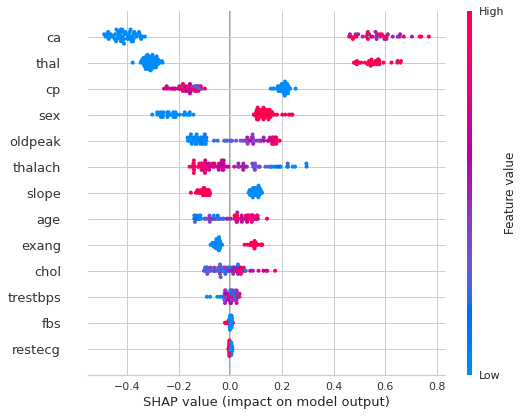

In [ ]:
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_test_preprocessed)

shap.summary_plot(shap_values, X_test_preprocessed)

SHAP summary plots provide the view of feature importance and how they contribute to prediction. The features on the left are the features used in the model and are ordered by their importance. The color represents the value of each feature from low to high, and the horizontal axis shows how the change in the value cause higher or lower prediction. Overall, the horizontal axis in SHAP summary plot display similar insight to what has been discovered in EDA.

In the plot, we could see `ca` play significant role to the model output. Patient with low `ca` affect the prediction drop far lower (no heart disease) and vice versa. Conversely, `fbs` and `restecg` seems to be ignored since their values have hardly noticeable impact to the prediction.

To get better understanding on how each feature affects the results, we will see the individual predictions for each value of the target (heart disease and no heart disease)

### Individual SHAP

In [ ]:
def individual_shap(model,patient_data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values([patient_data])
    shap.initjs()
    return shap.force_plot(explainer.expected_value, shap_values, patient_data)

#### Heart Disease

In [ ]:
individual_shap(cb,X_test_preprocessed.iloc[88])

The red bars signify the features that increase the prediction of heart disease, while the blue bars indicate the opposite. Moreover, the length of the bars shows the magnitude of impact to predictions.

In this case, the patient has been predicted with heart disease. The highest impact of heart disease prediction comes from `ca` being 1. In contrast, the `thal` value of 2 (normal) has the biggest impact to reduce the prediction into no heart disease. However, the total impact of the red bars outnumber the blue resulting in the heart disease prediction.

#### No Heart Disease

In [ ]:
individual_shap(cb,X_test_preprocessed.iloc[50])

The prediction of this patient is no heart disease. Likewise, the highest impact of prediction comes from `ca`, although the value is 0 and thus affect the prediction into no heart disease. Meanwhile, `age` and other red variable values increase the prediction slightly higher.